<a href="https://colab.research.google.com/github/rant95/Advanced-artificial-intelligence/blob/main/Projet_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projet Generation GAN Face

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Import dataset via API Kaggle

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

In [2]:
%cd /content/drive/MyDrive/Colab Notebooks/GAN
!ls

/content/drive/MyDrive/Colab Notebooks/GAN
celeba-dataset.zip  img_align_celeba


In [ ]:

#!kaggle datasets download -d jessicali9530/celeba-dataset

In [ ]:
#!unzip celeba-dataset.zip

In [3]:

%cd /content/drive/MyDrive/Colab Notebooks/GAN/img_align_celeba/img_align_celeba/
#!ls

/content/drive/MyDrive/Colab Notebooks/GAN/img_align_celeba/img_align_celeba


#  Load the dataset 

In [4]:
from tqdm import tqdm
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
from PIL import Image
from keras.layers import * 
from keras.models import Model
from tensorflow.keras.optimizers import RMSprop
import time

In [9]:
PIC_DIR = '/content/drive/MyDrive/Colab Notebooks/GAN/img_align_celeba/img_align_celeba/'
IMAGES_COUNT = 10000
ORIG_WIDTH = 178
ORIG_HEIGHT = 208
diff = (ORIG_HEIGHT - ORIG_WIDTH) // 2
WIDTH = 128
HEIGHT = 128
crop_rect = (0, diff, ORIG_WIDTH, ORIG_HEIGHT - diff)

In [ ]:


images = []
for pic_file in tqdm(os.listdir(PIC_DIR)[:IMAGES_COUNT]):
    pic = Image.open(PIC_DIR + pic_file).crop(crop_rect)
    pic.thumbnail((WIDTH, HEIGHT), Image.ANTIALIAS)
    images.append(np.uint8(pic)) #Normalize the images


100%|██████████| 10000/10000 [30:21<00:00,  5.49it/s]


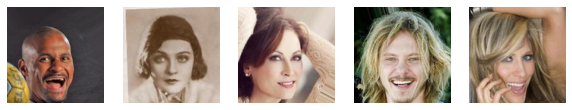

In [ ]:
images = np.array(images) / 255
images.shape #print first 5 images
plt.figure(1, figsize=(10, 10))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(images[i])
    plt.axis('off')
plt.show()

In [10]:
LATENT_DIM = 32
CHANNELS = 3
def create_generator():
    gen_input = Input(shape=(LATENT_DIM, ))
    
    x = Dense(128 * 16 * 16)(gen_input)
    x = LeakyReLU()(x)
    x = Reshape((16, 16, 128))(x)
    
    x = Conv2D(256, 5, padding='same')(x)
    x = LeakyReLU()(x)
    
    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)
    
    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)
    
    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)
    
    x = Conv2D(512, 5, padding='same')(x)
    x = LeakyReLU()(x)
    x = Conv2D(512, 5, padding='same')(x)
    x = LeakyReLU()(x)
    x = Conv2D(CHANNELS, 7, activation='tanh', padding='same')(x)
    
    generator = Model(gen_input, x)
    return generator

In [11]:
def create_discriminator():
    disc_input = Input(shape=(HEIGHT, WIDTH, CHANNELS))
    
    x = Conv2D(256, 3)(disc_input)
    x = LeakyReLU()(x)
    
    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)
    
    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)
    
    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)
    
    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)
    
    x = Flatten()(x)
    x = Dropout(0.4)(x)
    
    x = Dense(1, activation='sigmoid')(x)
    discriminator = Model(disc_input, x)
    
    optimizer = RMSprop(
        lr=.0001,
        clipvalue=1.0,
        decay=1e-8
    )
    
    discriminator.compile(
        optimizer=optimizer,
        loss='binary_crossentropy'
    )
    
    return discriminator

In [12]:
from keras.layers import * 
from keras.models import Model
from tensorflow.keras.optimizers import RMSprop
generator = create_generator()
discriminator = create_discriminator()
discriminator.trainable = False
gan_input = Input(shape=(LATENT_DIM, ))
gan_output = discriminator(generator(gan_input))
gan = Model(gan_input, gan_output)#Adversarial Model
optimizer = RMSprop(lr=.0001, clipvalue=1.0, decay=1e-8)
gan.compile(optimizer=optimizer, loss='binary_crossentropy')

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [8]:
import time
from PIL import Image
iters = 10000
batch_size = 16
RES_DIR = 'res4'

In [ ]:

FILE_PATH = '%s/generated_%d.png'
if not os.path.isdir(RES_DIR):
    os.mkdir(RES_DIR)
CONTROL_SIZE_SQRT = 6
control_vectors = np.random.normal(size=(CONTROL_SIZE_SQRT**2, LATENT_DIM)) / 2
start = 0
d_losses = []
a_losses = []
images_saved = 0
for step in range(iters):
    start_time = time.time()
    latent_vectors = np.random.normal(size=(batch_size, LATENT_DIM))
    generated = generator.predict(latent_vectors)
    
    real = images[start:start + batch_size]
    combined_images = np.concatenate([generated, real])
    
    labels = np.concatenate([np.ones((batch_size, 1)), np.zeros((batch_size, 1))])
    labels += .05 * np.random.random(labels.shape)
    
    d_loss = discriminator.train_on_batch(combined_images, labels)
    d_losses.append(d_loss)
    
    latent_vectors = np.random.normal(size=(batch_size, LATENT_DIM))
    misleading_targets = np.zeros((batch_size, 1))
    
    a_loss = gan.train_on_batch(latent_vectors, misleading_targets)
    a_losses.append(a_loss)
    
    start += batch_size
    if start > images.shape[0] - batch_size:
        start = 0
    
    if step % 50 == 49:
        gan.save_weights('gan2.h5')
        
        print('%d/%d: d_loss: %.4f,  a_loss: %.4f.  (%.1f sec)' % (step + 1, iters, d_loss, a_loss, time.time() - start_time))
        
        control_image = np.zeros((WIDTH * CONTROL_SIZE_SQRT, HEIGHT * CONTROL_SIZE_SQRT, CHANNELS))
        control_generated = generator.predict(control_vectors)
        for i in range(CONTROL_SIZE_SQRT ** 2):
            x_off = i % CONTROL_SIZE_SQRT
            y_off = i // CONTROL_SIZE_SQRT
            control_image[x_off * WIDTH:(x_off + 1) * WIDTH, y_off * HEIGHT:(y_off + 1) * HEIGHT, :] = control_generated[i, :, :, :]
        im = Image.fromarray(np.uint8(control_image * 255))
        im.save(FILE_PATH % (RES_DIR, images_saved))
        images_saved += 1

50/10000: d_loss: 0.6140,  a_loss: 0.6096.  (1.2 sec)
100/10000: d_loss: 0.6628,  a_loss: 0.8814.  (1.7 sec)
150/10000: d_loss: 1.0195,  a_loss: 0.9519.  (1.7 sec)
200/10000: d_loss: 0.6627,  a_loss: 1.0102.  (1.9 sec)
250/10000: d_loss: 0.6986,  a_loss: 0.8706.  (1.7 sec)
300/10000: d_loss: 0.6544,  a_loss: 1.0506.  (1.6 sec)
350/10000: d_loss: 0.7250,  a_loss: 0.7728.  (1.6 sec)
400/10000: d_loss: 0.6188,  a_loss: 0.8854.  (1.7 sec)
450/10000: d_loss: 0.6790,  a_loss: 0.8942.  (1.7 sec)
500/10000: d_loss: 0.6799,  a_loss: 0.9805.  (1.7 sec)
550/10000: d_loss: 0.6303,  a_loss: 0.8821.  (1.8 sec)
600/10000: d_loss: 0.7399,  a_loss: 0.7828.  (1.6 sec)
650/10000: d_loss: 0.6680,  a_loss: 0.7599.  (1.7 sec)
700/10000: d_loss: 0.6763,  a_loss: 0.7987.  (1.7 sec)
750/10000: d_loss: 0.6570,  a_loss: 0.8904.  (1.7 sec)
800/10000: d_loss: 0.6770,  a_loss: 0.9012.  (1.7 sec)
850/10000: d_loss: 0.6756,  a_loss: 0.9223.  (1.6 sec)
900/10000: d_loss: 0.6551,  a_loss: 1.0268.  (1.6 sec)
950/10000: 

In [13]:

import imageio
import shutil
images_to_gif = []
for filename in os.listdir(RES_DIR):
    images_to_gif.append(imageio.imread(RES_DIR + '/' + filename))
imageio.mimsave('trainnig_visual1.gif', images_to_gif,duration = 0.5)
shutil.rmtree(RES_DIR)


In [ ]:
from IPython.display import HTML
HTML('<iframe src="https://giphy.com/embed/qZeghLHePgNUVryrfF" width="480" height="480" frameBorder="0" class="giphy-embed" allowFullScreen></iframe><p><a href="https://giphy.com/gifs/qZeghLHePgNUVryrfF">via GIPHY</a></p>')